In [1]:
%pylab inline
import numpy as np
import numpy.linalg as LA
import time
import pandas as pd
import os
import matplotlib.pyplot as plt


from scipy.sparse.linalg import spsolve
from scipy import sparse


Populating the interactive namespace from numpy and matplotlib


$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$

# Project 4
**Your group member:**

- The deadline is Apr 16th 11:59pm. Submission after the deadline will not be graded.

- This is a group projection. Your group only needs to submit one project. You can form a group of 1, 2 or 3.

- Submit your work(your reasoning and your code) as a SINGLE .ipynb document. Please rename the document as _HW1_YOURNAME.ipynb_ (for example, _HW1_FELIX.ipynb_). You are responsible for checking that you have correctly submitted the correct document. If your code cannot run, you may receive NO point.


- Please justify all short answers with a brief explanation.

- You only use the Python packages included in the following cell. You are not allowed to use other advanced package or modules unless you are permitted to.

- In your final submission include the plots produced by the unedited code as presented below, as well as any additional plots produced after editing the code during the course of a problem. You may find it necessary to copy/paste relevant code into additional cells to accomplish this.

- Feel free to use the lecture notes and other resources.


- **You must write your own code and fill in the your answer in the text box.** If you fail to do either of that, you will receive zero point.






# Part 1: Matrix Factorization for Movie Lens Recommendations



### Data preparation (Read carefully!)
In this problem, you will look at a portion of the  movie rating dataset, which
has ratings that users have given to movies. It is a dataset of 1 million movie ratings (from 1 to 5) available from the MovieLens project. The MovieLens datasets were created collected by GroupLens Research at the University of Minnesota.

We want to include the metadata (movie titles, etc), not just the ratings matrix.

In [2]:

!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m
!ls

folder = 'ml-1m'


--2025-04-17 01:15:48--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.2’

ml-1m.zip.2         100%[===================>]   5.64M  14.8MB/s    in 0.4s    

2025-04-17 01:15:48 (14.8 MB/s) - ‘ml-1m.zip.2’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: artists.txt  ml-1m.zip	  ml-1m.zip.2  user_artists_small.txt
ml-1m	     ml-1m.zip.1  sample_data  user_artists.txt


In [3]:
ratings_list = [ [int(x) for x in i.strip().split("::")] for i in open(os.path.join(folder,'ratings.dat'), 'r').readlines()]
users_list = [i.strip().split("::") for i in open(os.path.join(folder, 'users.dat'), 'r').readlines()]
movies_list = [i.strip().split("::") for i in open(os.path.join(folder, 'movies.dat'), 'r',  encoding="latin-1").readlines()]

ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
def get_movie_name(movies_df, movie_id_str):
  ndx = (movies_df['MovieID']==int(movie_id_str))
  name = movies_df['Title'][ndx].to_numpy()[0]
  return name

def get_movie_genres(movies_df, movie_id_str):
  ndx = (movies_df['MovieID']==int(movie_id_str))
  name = movies_df['Genres'][ndx].to_numpy()[0]
  return name

print('Movie with Moive ID 1 is ', get_movie_name(movies_df, 1))
print('The corresponding genres is ',get_movie_genres(movies_df, 1))
print('Movie with Moive ID 527 is ', get_movie_name(movies_df, "527"))
print('The corresponding genres is ', get_movie_genres(movies_df, "527"))

ratings_df.head()

Movie with Moive ID 1 is  Toy Story (1995)
The corresponding genres is  Animation|Children's|Comedy
Movie with Moive ID 527 is  Schindler's List (1993)
The corresponding genres is  Drama|War


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


These look good, but I want the format of my ratings matrix to be one row per user and one column per movie. I'll `pivot` `ratings_df` to get that and call the new variable `R`.

In [5]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
R = R_df.to_numpy()
R.shape

(6040, 3706)

Similarly we mask a random sample of the user/item ratings to validate and compare how well the recommender system did in predicting the ratings of those masked values. In our case, given we already know each user has given more than 10 ratings, what we'll do is for every user, we remove 10 of the item ratings and and assign them to the test set.

In [103]:
def create_train_test(R, num_remove=5):
    """
    split into training and test sets,
    remove 5 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(R.shape)
    train = R.copy()
    print(train.shape)
    for user in range(R.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(R[user]), size = num_remove, replace = False)

        train[user, test_index] = 0.0
        test[user, test_index] = R[user, test_index]

    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

Rtrain, Rtest = create_train_test(R)
print("Training shape:", Rtrain.shape)
print("Testing shape:", Rtest.shape)

(6040, 3706)
Training shape: (6040, 3706)
Testing shape: (6040, 3706)




---


## Warm up task 1: SVD (10pt)
The simpliest matrix factorization method is SVD.



### **Your task:**
- Each row(user) subtract by each user mean, which normalize each user rating.

- Perform SVD on the normalized `R` and choose the latent factors $k=10,30,50$.

- Calculate the rank=$k$ approximation of $R$. You also need to add the user means back to get the actual ratings prediction, denote this rating matrix as `R_k`

- Now some of entries may be out of rating range $[0,5]$. Please set entries that are larger than 5 to 5 and set entries that are smaller than 0 to 0.

- Compute MSE for training and testing dataset in all three $k$ situations. Which $k$ performs the best in testing dataset?  You need to use the MSE function used in the class.


In [9]:
def MSE(y,pred):
    """ignore zero terms prior to comparing the mse"""
    y_ravel = y.ravel()
    pred_ravel  = pred.ravel()
    mask = np.nonzero(y_ravel)
    mse = np.sqrt(np.sum( (y_ravel[mask]- pred_ravel[mask])**2 )/np.shape(mask)[1])
    return mse

In [10]:
# Your code starts here

## normalize R by rows and store means for adding back
R = R.copy()
means = []

for i in range(R.shape[0]):
    m = np.mean(R[i,:])
    means.append(m)
    R[i,:] -= m


In [11]:
## SVD
# important note: LA.svd calculates V to be the transpose already
U,S,V = LA.svd(R)


MSEs for k=10:
Training: 2.5167886630065652
Testing: 2.990991770161539

MSEs for k=20:
Training: 2.394111077631765
Testing: 2.8296643286953933

MSEs for k=30:
Training: 2.319753608192923
Testing: 2.7310422799705143

MSEs for k=40:
Training: 2.2644522308513952
Testing: 2.657746483607717

MSEs for k=50:
Training: 2.2178904382079923
Testing: 2.5978553344833157



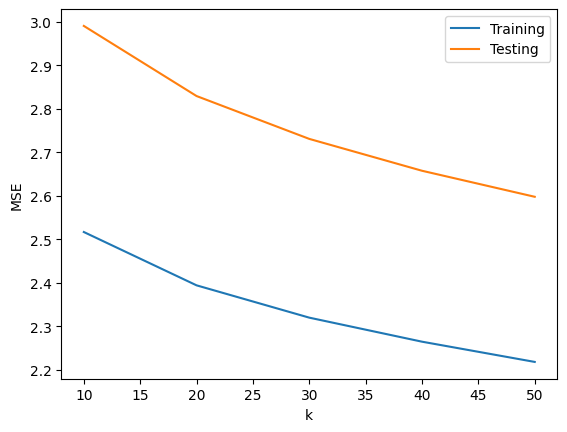

In [12]:
## rank k approx
def k_approx(U,S,V,means,k):
    """
    Calculates the rank k approximation of a matrix, given its SVD

    Args:
        U,S,V: SVD of a matrix
        k: rank of the approximation
    Returns:
        R_k: rank k approximation of R
    """

    U_k = U[:,:k] # mxk
    S_k = np.diag(S[:k]) # kxk
    V_k = V[:k,:] # kxn
    R_k = U_k.dot(S_k).dot(V_k)

    ## add back means
    for i in range(R_k.shape[0]):
        R_k[i] = R_k[i] + means[i]

    ## replace values too large
    R_k[R_k>5] = 5
    R_k[R_k<0] = 0

    return R_k

K=range(10,51,10)
Ktr_scores=[]
Kte_scores=[]

for k in K:
    # get rank-k approximation
    R_k = k_approx(U,S,V,means,k)

    ## create train, test for R_k
    Rk_train, Rk_test = create_train_test(R_k)

    ## calculate MSE
    print(f"MSEs for k={k}:")
    tr_mse = MSE(Rtrain, R_k)
    te_mse = MSE(Rtest, R_k)
    print(f"Training: {tr_mse}")
    print(f"Testing: {te_mse}")
    Ktr_scores.append(tr_mse)
    Kte_scores.append(te_mse)
    print()

## plot mse
plt.plot(K,Ktr_scores,label="Training")
plt.plot(K,Kte_scores,label="Testing")
plt.xlabel("k")
plt.ylabel("MSE")
plt.legend()
plt.show()


### Make Movie Recommendations
Finally, it's time. With the predictions matrix for every user, I can build a function to recommend movies for any user. All I need to do is return the movies with the highest predicted rating that the specified user hasn't already rated. Though I didn't use actually use any explicit movie content features (such as genre or title), I'll merge in that information to get a more complete picture of the recommendations.

I'll also return the list of movies the user has already rated, for the sake of comparison.

In [22]:
def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations=5):

    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1

    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.UserID == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'MovieID', right_on = 'MovieID').
                     sort_values(['Rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))

    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['MovieID'].isin(user_full['MovieID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'MovieID',
               right_on = 'MovieID').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [232]:
# R_k with optimal k is the low rank matrix you have constructed previously
preds_df = pd.DataFrame(R_k, columns = R_df.columns)
preds_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,0.000000,0.000000,0.012232,0.000000,0.000000,0.141358,0.000000,0.000000,...,0.027807,0.00164,0.026395,0.000000,0.000000,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,0.000000,0.00000,0.000000,0.062576,0.000000,0.155790,0.000000,0.000000,0.000000,0.000000
2,1.818824,0.456136,0.090978,0.000000,0.000000,0.000000,0.000000,0.098977,0.030551,0.735470,...,0.040481,0.00000,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,0.000000
3,0.408057,0.000000,0.039642,0.089363,0.041950,0.237753,0.000000,0.009467,0.045469,0.000000,...,0.008571,0.00000,0.000000,0.000000,0.000000,0.094512,0.057557,0.000000,0.014841,0.000000
4,1.574272,0.021239,0.000000,0.246884,0.000000,1.552281,0.000000,0.000000,0.000000,0.450512,...,0.110151,0.04601,0.006934,0.000000,0.000000,0.000000,0.507189,0.033830,0.125706,0.199244


In [41]:
# Let's check for user 837
already_rated, predictions = recommend_movies(preds_df, 837, movies_df, ratings_df, 10)
already_rated.head(10)


User 837 has already rated 69 movies.
Recommending highest 10 predicted ratings movies not already rated.


,UserID,MovieID,Rating,Timestamp,Title,Genres
65,837,2028,5,975360089,Saving Private Ryan (1998),Action|Drama|War
36,837,858,5,975360036,"Godfather, The (1972)",Action|Crime|Drama
35,837,1387,5,975360036,Jaws (1975),Action|Horror
20,837,3417,5,975360893,"Crimson Pirate, The (1952)",Adventure|Comedy|Sci-Fi
11,837,913,5,975359921,"Maltese Falcon, The (1941)",Film-Noir|Mystery
63,837,1221,5,975360036,"Godfather: Part II, The (1974)",Action|Crime|Drama
47,837,318,4,975359812,"Shawshank Redemption, The (1994)",Drama
55,837,2791,4,975360893,Airplane! (1980),Comedy
58,837,2944,4,975360120,"Dirty Dozen, The (1967)",Action|War
2,837,1252,4,975359887,Chinatown (1974),Film-Noir|Mystery|Thriller


In [234]:
# here is your prediction. Does it make sense? please comment your result.
predictions

,MovieID,Title,Genres
516,527,Schindler's List (1993),Drama|War
1848,1953,"French Connection, The (1971)",Action|Crime|Drama|Thriller
596,608,Fargo (1996),Crime|Drama|Thriller
1235,1284,"Big Sleep, The (1946)",Film-Noir|Mystery
2085,2194,"Untouchables, The (1987)",Action|Crime|Drama
1188,1230,Annie Hall (1977),Comedy|Romance
1198,1242,Glory (1989),Action|Drama|War
897,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
1849,1954,Rocky (1976),Action|Drama
581,593,"Silence of the Lambs, The (1991)",Drama|Thriller


### Your solution:

The predictions we got seem to fit with what user $837$ has already seen. We haven't taken into account their preferred genres yet, but there are no repeat movies in what user $837$ has seen and the ones we've recommended to them and, while I don't specifically see the ratings of the predicted movies, I know anecdotally they are highly rated.



---


## Warm up task 2: Non-negative matrix (15pt)
$W$ and $H$ values in matrix Factorization are non interpretable since their components can take arbitrary (positive and negative) values.

The objective function of non-negative matrix factorization is
\begin{align}
\min_{W\in \mb{R}^{M\times k}, H\in \mb{R}^{N\times k}} \|A-WH^\top\|_F^2 + \lambda \left(\|W\|_F^2 + \|H\|_F^2\right), \text{ subject to } W\ge 0, H\ge 0.
\end{align}

### **Your task:**
- Implement Lee and Seung's multiplicative update rule as discussed in the notebook, with the latent factor $k=10$ and $\lambda=0.6$

- Compute MSE for training and testing dataset. You need to use the MSE function used in class.

- Please check your recommendation prediction for the user 837. Does it make sense?

- Check the matrix $W$, does it fit the preference of genres for the user? You can cross-check some rows.

- Check the matrix $H$, does it fit the description of genres for the movie? You can cross-check some rows.




**Input:** partially observed matrix $A$, initial values of non-negative $W$ , $H$:

Update the values in $W$ and $H$ by computing the following, with $t$ as an index of the iteration.

- For $t = 1, 2,\dots$,
  - $ W_{ij}^{(t+1)}\leftarrow \frac{W_{ij}^{(t)} (AH^{(t)})_{ij}}{\lambda W^{(t)}_{ij} + (W^{(t)}(H^{(t)})^\top H^{(t)})_{ij}}$

  - $H_{ij}^{(t+1)} \leftarrow \frac{H_{ij}^{(t)}(A^\top W^{(t+1)})_{ij}}{\lambda H^{(t)}_{ij} + (H^{(t)}(W^{(t+1)})^\top W^{(t+1)} )_{ij}}  $

  - Until $W^{(t)}$ and $H^{(t)}$ are stable.

init opt val: 1174160655.8072417
Updating W, H...
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 10:
Current Opt Val: 5140882.702
Current Diff: 46525.056
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 20:
Current Opt Val: 4701062.757
Current Diff: 23035.357
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 30:
Current Opt Val: 4569983.351
Current Diff: 7474.613
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 40:
Current Opt Val: 4525933.659
Current Diff: 2820.872
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 50:
Current Opt Val: 4505984.18
C

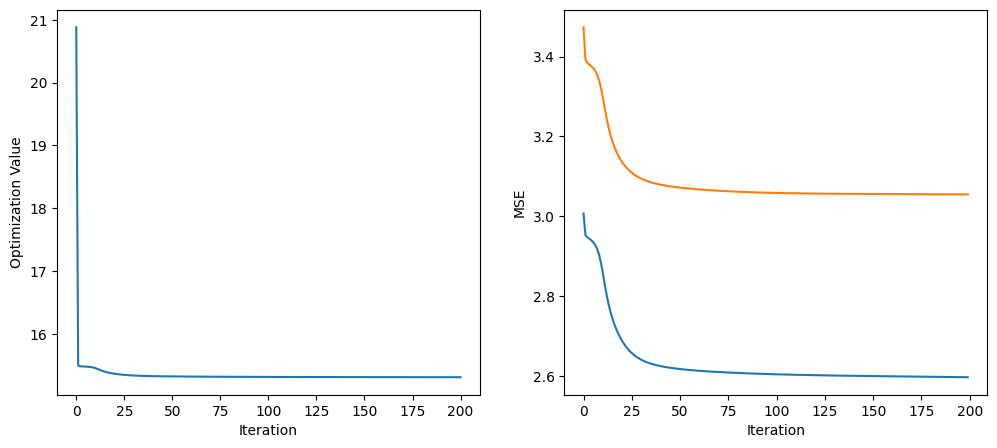

In [27]:
## Lee and Seung's multiplicative update rule

def LS_update_W(A, W, H, lam):

    AH = A.dot(H)
    WHH = W.dot(H.T).dot(H)
    m,k = W.shape
    for i in range(m):
        for j in range(k):
            W[i,j] = W[i,j]*(AH[i,j] / (lam*W[i,j] + WHH[i,j]))

    return W

def LS_update_H(A, W, H, lam):

    AW = (A.T).dot(W)
    HWW = H.dot(W.T).dot(W)
    n,k = H.shape
    for i in range(n):
        for j in range(k):
            H[i,j] = H[i,j]*(AW[i,j] / (lam*H[i,j] + HWW[i,j]))

    return H

def stable(A, W, H, lam):
    """
    Calculates the optimization value
    """
    first = LA.norm(A-(W.dot(H.T)), 'fro')**2
    second = lam*(LA.norm(W, 'fro')**2 + LA.norm(H, 'fro')**2)
    return (first + second)/2

def nonneg_mat_fact(A, k=10, lam=.6, threshold=100, max_iter=100,
                    give_updates=True, update_freq=10):
    """
    Non-negative matrix factorization

    Args:
        A: dataset
        k: dim for W, H factorization
        lam: regularization value
        threshold: threshold to determine stability, defaults to 100
        max_iter: maximum iterations to use, defaults to 100
        give_updates: whether to give updates when training, defaults to True
        update_freq: frequency to give updates between iterations, defaults to 5
    Returns:
        W: updated W
        H: updated H
    """
    ## train test split
    train, test = create_train_test(A)

    ## initialization
    W = np.random.random((A.shape[0],k))*2
    H = np.random.random((A.shape[1],k))*2
    t=1
    prev_stab = stable(A, W, H, lam)
    print("init opt val:", prev_stab)
    stabs = [prev_stab]
    train_mses = []
    test_mses = []

    print("Updating W, H...")
    ## optimization loop
    while t <= max_iter:
        print(f"Iteration {t}")
        # updates
        W = LS_update_W(A, W, H, lam)
        H = LS_update_H(A, W, H, lam)

        # optimization val
        stab = stable(A, W, H, lam)
        stabs.append(stab)
        diff = prev_stab - stab

        # mses
        WH = W.dot(H.T)
        train_mses.append(MSE(train, WH))
        test_mses.append(MSE(test, WH))

        # update check-up (every 5 updates by default)
        if give_updates and t%update_freq==0:
            print(f"Iteration {t}:")
            print(f"Current Opt Val: {np.round(stab,3)}")
            print(f"Current Diff: {np.round(diff,3)}")

        if np.abs(diff) < threshold:
            print("Optimization stabilized!")
            break
        elif t == max_iter:
            print(f"Max Iterations Reached (t={max_iter})")
        else:
            prev_stab = stab

        t+=1
        ## loop end

    # plots
    fig, axs = plt.subplots(1,2,figsize=(12,5))
    axs[0].plot(np.log(stabs))
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Optimization Value")
    axs[1].plot(train_mses, label="Training")
    axs[1].plot(test_mses, label="Testing")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("MSE")

    plt.show()

    return W,H

# gets good convergence at around 150 iterations
W_ls,H_ls = nonneg_mat_fact(R, max_iter=150)


In [28]:
WH = W_ls.dot(H_ls.T)

print(f"Training MSE: {MSE(Rtrain, WH)}")
print(f"Testing MSE: {MSE(Rtest, WH)}")

Training MSE: 2.5972698370400344
Testing MSE: 3.068195353185835


In [29]:
preds_df = pd.DataFrame(WH, columns = R_df.columns)
already_rated, predictions = recommend_movies(preds_df, 837, movies_df, ratings_df, 10)
predictions

User 837 has already rated 69 movies.
Recommending highest 10 predicted ratings movies not already rated.


,MovieID,Title,Genres
888,912,Casablanca (1942),Drama|Romance|War
885,908,North by Northwest (1959),Drama|Thriller
898,923,Citizen Kane (1941),Drama
1188,1230,Annie Hall (1977),Comedy|Romance
1202,1247,"Graduate, The (1967)",Drama|Romance
1157,1193,One Flew Over the Cuckoo's Nest (1975),Drama
596,608,Fargo (1996),Crime|Drama|Thriller
882,904,Rear Window (1954),Mystery|Thriller
1204,1250,"Bridge on the River Kwai, The (1957)",Drama|War
516,527,Schindler's List (1993),Drama|War


### Your Solution:

We have somewhat of a significant change. While a few movies are the same - just at a different index - the movies that were replaced were done so by movies that fit the overall "theme" of genres user $837$ reviewed in the past (more Crime, Drama, Thriller movies). The matrices $W$ and $H$ (should theretically) connect the User x Genre ($W$) information and the Genre x Movie ($H$) information when we multipliy them, giving a score personalized for each user to each movie.

Since we index starting at $0$, the genre data for user $837$ is at $W_{836}$ and each movie with $MovieID = n$ correlates to $H_{n-1}$. We can look at the proper rows for each movie above and see how their genre information relate to $W_{836}$.

In [39]:
user = W_ls[836]
print("User 837")
print(W_ls[836])

User 837
[9.40853086e-002 3.44618646e-002 1.63481150e-001 2.77835329e-002
 9.20459018e-003 1.43184051e-039 1.42224485e-048 3.99396764e-003
 2.55798005e-116 1.00436431e-049]


Let's check three of the top movies: *Cassablanca* ($W_{911}$), *Citizen Kane* ($W_{922}$) and *Fargo* ($W_{607}$):

In [37]:
h_list = [911, 922, 607]
names = ['Cassablanca', 'Citizen Kane', 'Fargo']
for i in range(3):
    print(names[i])
    print(H_ls[h_list[i]])


Cassablanca
[4.96508002e-118 4.31847142e-056 4.97634552e-002 2.37578337e-036
 6.73995369e-192 3.91600805e-002 1.93134774e-002 3.51158675e-225
 5.86858876e-023 1.92790060e-144]
Citizen Kane
[0.00000000e+000 4.07991005e-182 4.56032077e-003 2.78868633e-002
 2.70064842e-026 1.05281262e-002 9.12102682e-049 0.00000000e+000
 7.27469566e-220 1.54602665e-021]
Fargo
[2.07875073e-076 3.24948260e-150 3.04059100e-003 2.91552127e-034
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000]


We can see that certain parts of the movie/genre vectors correlate to the higher values in $W_{836}$, specifically the third entry in each vector. Since each of these movies are dramas and the user has plenty of drama movies highly rated, we can deduce that this third entry in each vector correlate to drama-type films to some extent.



---
## Your task: Freeride (35pt)
Implement any algorithm you’d like (you must implement it yourself; do not use an off-the-shelf algorithm) to find an estimator that achieves a test MSE error better than these in warm up tasks. You need to use the MSE function used in class. However, you may use all machine learning modules we learnt in this course.


## **Freeride Intro**

Our goal here is to beat the benchmark MSE scored by our "warm-up" problems above. It's important to note that the MSE for the $R_k$ approximation was a test, not an actualization. The real MSE we want to improve on is the one calculated from the Lee and Seung multiplication rule, which was $MLE^{ls}_{tr} = 2.6$ and $MLE^{ls}_{te} = 3.1$. The $R_k$ approximations do not consider genre data when training, so their values shouldn't necessary to completely surpass.

The goal is to beat these MSEs with our latent factors $k=10$. It should follow that changing the latent factors to a higher value will match that of the $R_k$ approximation MSE. For reference:

\begin{align}
MSE^{R_{10}}_{tr} = 2.516 &, MSE^{R_{10}}_{te} = 2.991\\
MSE^{R_{30}}_{tr} = 2.320 &, MSE^{R_{30}}_{te} = 2.731\\
MSE^{R_{50}}_{tr} = 2.218 &, MSE^{R_{50}}_{te} = 2.588.
\end{align}

Since we've only touched on one of the few methods used to analyze these types of problems discussed in class, we will begin by implementing and using these. The methods were:

*   Direct Low Rank Matrix Factorization w/ Alternating Least Squares (**ALS**)
*   Stochastic Gradient Descent (**SGD**)
*   Matrix-norm Minimization
*   Feature-based Recommendation w/ Inductive Matrix Completion (**IMC**)

With no specific order in mind, we'll start with **ALS**, then move on to **SVD** if that isn't an improvement.


### **ALS Approach**

#### **Algorithm**

- **Input:** partially observed matrix $A$, initial values of $W$, $H$.

- For $t=1,2,\dots$

 - Fix $H$ and update $W$: $W \leftarrow AH(H^\top H+\lambda I)^{-1}$.

 - Fix $W$ and update $H$: $H \leftarrow A^\top W(W^\top W+\lambda I )^{-1}$.

 - Do until $max\_iter$ is reached.




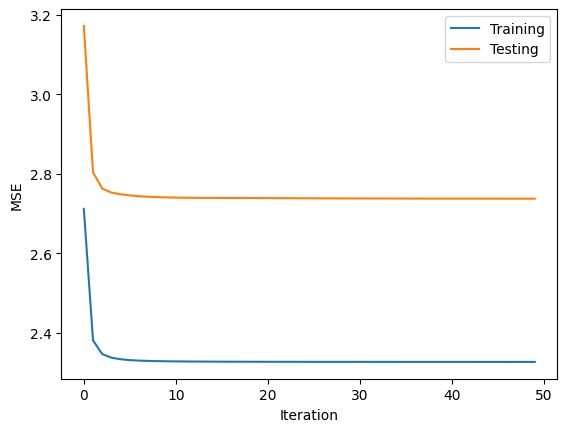

In [80]:
def als_step(train, fixed, k, lam):
	A = fixed.T.dot(fixed) + np.eye(k) * lam
	b = train.dot(fixed)
	solve_matrix = LA.solve(A,b.T).T
	return solve_matrix

def ALS(A, k=10, lam=.01, max_iter=100):
	# train test split
	train, test = create_train_test(A)

	# initialization
	W = np.random.random((train.shape[0],k))
	H = np.random.random((train.shape[1],k))
	t = 1
	train_mses = []
	test_mses = []

	# update loop
	while t <= max_iter:
		# update W, H
		W = als_step(A,   H, k, lam)
		H = als_step(A.T, W, k, lam)
		WH = W.dot(H.T)
		train_mses.append(MSE(train,WH))
		test_mses.append(MSE(test,WH))
		t+=1
		# end update loop

	# plots
	plt.plot(train_mses, label="Training")
	plt.plot(test_mses, label="Testing")
	plt.xlabel("Iteration")
	plt.ylabel("MSE")
	plt.legend()
	plt.show()

	return W, H

W_als,H_als = ALS(R,k=10,max_iter=50)


In [81]:
WH = W_als.dot(H_als.T)
print(f"Training MSE from ALS: {MSE(Rtrain, WH)}")
print(f"Testing MSE from ALS: {MSE(Rtest, WH)}")

Training MSE from ALS: 2.3272677756643425
Testing MSE from ALS: 2.7362975701165744


#### **Recommendations**

The recommendations here are pretty similar to those above. Our MSE is also improved when compared to the Lee and Seung implementation above, giving us an MSE improvement of roughly a tenth. When increasing latent factors to $50$, we get are only slightly under the arbitrary benchmark put up by the $R_k$ approximation.

The difference is insubstantial given the generation of the ALS recommendations uses the genre data, so the recommendations will both be better than the Lee and Seung implementation and have practically the same error as the benchmark $R_k$ approximations.

\begin{align}
k=10: \text{   } & MSE^{als}_{tr} = 2.526 , MSE^{als}_{te} = 2.997\\
k=30: \text{   } & MSE^{als}_{tr} = 2.328 , MSE^{als}_{te} = 2.736\\
k=50: \text{   } & MSE^{als}_{tr} = 2.225 , MSE^{als}_{te} = 2.603
\end{align}

In [83]:
preds_df = pd.DataFrame(WH, columns = R_df.columns)
already_rated, predictions = recommend_movies(preds_df, 837, movies_df, ratings_df, 10)
predictions

User 837 has already rated 69 movies.
Recommending highest 10 predicted ratings movies not already rated.


,MovieID,Title,Genres
596,608,Fargo (1996),Crime|Drama|Thriller
516,527,Schindler's List (1993),Drama|War
1848,1953,"French Connection, The (1971)",Action|Crime|Drama|Thriller
581,593,"Silence of the Lambs, The (1991)",Drama|Thriller
19,21,Get Shorty (1995),Action|Comedy|Drama
1157,1193,One Flew Over the Cuckoo's Nest (1975),Drama
2085,2194,"Untouchables, The (1987)",Action|Crime|Drama
1175,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller
885,908,North by Northwest (1959),Drama|Thriller
1161,1198,Raiders of the Lost Ark (1981),Action|Adventure


We still desire to test the other algorithms used in lecture, even though this particular implementaion is sufficient.

### **SVD Approach**

#### Algorithm
- **Input:** partially observed matrix $A$, initial values of $W$ , $H$, and learning rate $\eta$:

- For $t = 1, 2,\dots$,
  
  - Randomly pick a pair $(i,j)\in \Omega$.

  - $W_u \leftarrow (1-\eta_t \lambda)W_u -\eta_t (W_uH_i^\top -A_{ui})H_i$

  - $H_i \leftarrow (1-\eta_t \lambda)H_i -\eta_t (W_uH_i^\top -A_{ui})W_u$


We've set up the ability for the user to run this SGD in parallel, if desired.

9136812.836042682
5834.005107957898
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
9408630.876302665
5957.762546226563
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
9432712.383440677
5952.798718388597
Current Loss: 4719332.591
Current Diff: -12038.272
Current Training MSE: 3.118
Current Testing MSE: 3.24
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
9655231.929300554
6044.130169653164
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
9689428.847440628
6078.794291277286
Current Loss: 4847753.821
Current Diff: -17115.791
Current Training MSE: 3.161
Current Testing MSE: 3.286
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
9870475.013297325
6186.5488543865085
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
9897337.141305214
6226.195293722507
Current Loss: 4951781.668
Current Diff: -13450.887
Current Training MSE: 3.194
Current Testing MSE: 3.322
Iteration 31
Iteration 32
Iteration 33
Iteration 

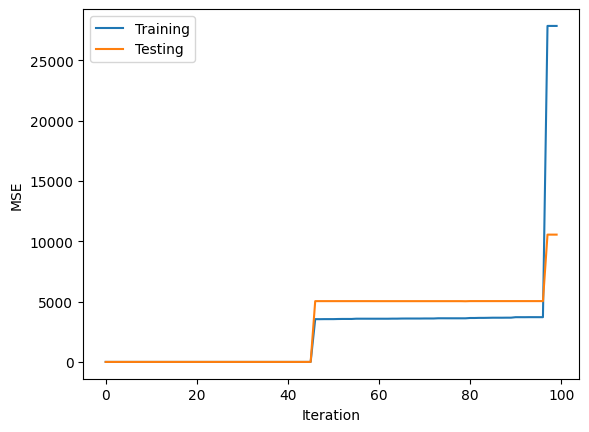

In [65]:
def loss_sgd(A, W, H, lam, Omega):
    left = 0
    for u,i in Omega:
        left += (A[u,i] - W[u].dot(H[i].T))**2
    right = lam*(LA.norm(W, 'fro')**2 + LA.norm(H, 'fro')**2)
    print(left)
    print(right)
    return (left + right)/2

def SGD(A, lam=.6, k=3, eta=1, threshold=100, max_iter=200,
        parallel=False, replacement=False, give_updates=True, update_freq=10):
    """
    SGD of a low-rank approximated matrix to yield a matrix factorization of A

    Args:
        A: dataset
        lam: regularization value
        k: dim for W, H factorization
        eta: learning rate
        diff_threshold: threshold to determine stability, defaults to 100
        max_iter: maximum iterations to use, defaults to 200
        parallel: whether to run parallelized SGD, defaults to False
        replacement: whether to pick pairs from Omega with replacement,
            defaults to False
        give_updates: whether to give updates when training, defaults to True
        update_freq: frequency to give updates between iterations, defaults to 5
    Returns:
        W: updated W
        H: updated H
    """
    # train test split
    train, test = create_train_test(A)

    # initialize W, H
    m,n = A.shape
    W = np.random.random((m,k))
    H = np.random.random((n,k))

    # initialize vector pairs, len = max_iter
    Omega_rows, Omega_cols = np.nonzero(train)
    Omega = list(zip(Omega_rows, Omega_cols))
    if parallel:
        users_1 = np.random.choice(Omega_rows, max_iter*3, replace=replacement)
        items_1 = np.random.choice(Omega_cols, max_iter*3, replace=replacement)
        pairs_1 = list(zip(users_1, items_1))
        users_2 = np.random.choice(Omega_rows, max_iter*3, replace=replacement)
        items_2 = np.random.choice(Omega_cols, max_iter*3, replace=replacement)
        pairs_2 = list(zip(users_2, items_2))
    else:
        users = np.random.choice(Omega_rows, max_iter, replace=replacement)
        items = np.random.choice(Omega_cols, max_iter, replace=replacement)
        pairs = list(zip(users, items))

    # initial controls
    t = 0
    stabilized = False
    prev_stab = loss_sgd(A, W, H, lam, Omega)
    losses = [prev_stab]
    train_mses = []
    test_mses = []
    if parallel:
        p = 0

    # update loop
    while not stabilized and t < max_iter:
        # get new pair
        if parallel:
            conflict = True
            while conflict:
                u1,i1 = pairs_1[p]
                u2,i2 = pairs_2[p]
                if u1 != u2 and i1 != i2:
                    conflict = False
                else:
                    p += 1
        else:
            u,i = pairs[t]

        # iterate t
        t += 1
        if parallel:
            p += 1
        print(f"Iteration {t}")

        # update row u of W and row i of H
        if parallel:
            W[u1] = ((1-(lam*eta))*W[u1]) - ((eta*(W[u1].dot(H[i1].T) - A[u1,i1]))*H[i1])
            W[u2] = ((1-(lam*eta))*W[u2]) - ((eta*(W[u2].dot(H[i2].T) - A[u2,i2]))*H[i2])
            H[i1] = ((1-(lam*eta))*H[i1]) - ((eta*(W[u1].dot(H[i1].T) - A[u1,i1]))*W[u1])
            H[i2] = ((1-(lam*eta))*H[i2]) - ((eta*(W[u2].dot(H[i2].T) - A[u2,i2]))*W[u2])
        else:
            W[u] = ((1-(lam*eta))*W[u]) - ((eta*(W[u].dot(H[i].T) - A[u,i]))*H[i])
            H[i] = ((1-(lam*eta))*H[i]) - ((eta*(W[u].dot(H[i].T) - A[u,i]))*W[u])
        # mses
        WH = W.dot(H.T)
        train_mses.append(MSE(train, WH))
        test_mses.append(MSE(test, WH))

        # only check loss and stability every 5 iterations
        if t%5==0:
            # calculate loss function value
            loss = loss_sgd(A, W, H, lam, Omega)
            losses.append(loss)

            # calculate derivative
            diff = prev_stab - loss

            # check for stability
            if np.abs(diff) < threshold:
                stabilized = True
                print("Optimization stabilized!")
            elif t == max_iter:
                print("Optimization did not converge!")
                print(f"Max Iterations Reached (t={max_iter})")
            else:
                prev_stab = loss

            # update check-up
            if give_updates and t%update_freq==0:
                print(f"Current Loss: {np.round(loss,3)}")
                print(f"Current Diff: {np.round(diff,3)}")
                print(f"Current Training MSE: {np.round(train_mses[-1],3)}")
                print(f"Current Testing MSE: {np.round(test_mses[-1],3)}")
        # end update loop
    print(p)
    # plots
    plt.plot(train_mses, label="Training")
    plt.plot(test_mses, label="Testing")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

    return W, H

W_sgd,H_sgd = SGD(R, max_iter=100, parallel=True)

In [66]:
WH = W_sgd.dot(H_sgd.T)
print(f"Training MSE from ALS: {MSE(Rtrain, WH)}")
print(f"Testing MSE from ALS: {MSE(Rtest, WH)}")

Training MSE from ALS: 27859.8087913065
Testing MSE from ALS: 10180.070773039179


#### **Recommendations**

Unfortunately, this algorithm appears to be a bit chaotic. We've not entirely sure how it is that such abrupt changes can come about from changing one or two vectors per iteration. We will post the recommendations regardless, but do not expect them to be in line with the others.

In [67]:
preds_df = pd.DataFrame(WH, columns = R_df.columns)
already_rated, predictions = recommend_movies(preds_df, 837, movies_df, ratings_df, 10)
predictions

User 837 has already rated 69 movies.
Recommending highest 10 predicted ratings movies not already rated.


,MovieID,Title,Genres
596,608,Fargo (1996),Crime|Drama|Thriller
1343,1396,Sneakers (1992),Crime|Drama|Sci-Fi
1170,1208,Apocalypse Now (1979),Drama|War
1198,1242,Glory (1989),Action|Drama|War
1161,1198,Raiders of the Lost Ark (1981),Action|Adventure
3315,3448,"Good Morning, Vietnam (1987)",Comedy|Drama|War
1173,1211,Wings of Desire (Der Himmel über Berlin) (1987),Comedy|Drama|Romance
3118,3244,"Goodbye Girl, The (1977)",Comedy|Romance
1095,1127,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller
157,162,Crumb (1994),Documentary


### **Projected Gradient Approach**

Since Projected Gradient and SGD have very similar implementations, we will check here if there are any profound differences between the two algorithms.

#### **Algorithm**

**Input:** partially observed matrix $A$, initial values of $W$ , $H$, and learning rate $\eta$.

- For $t = 1, 2,\dots$,
  
  - Randomly pick a pair $(i,j)\in \Omega$.

  - $\tilde W_u \leftarrow (1-\eta_t \lambda)W_u -\eta_t (W_uH_i^\top -A_{ui})H_i$

  - $W_u = (\tilde W_u)_{+}$, i.e., set all negative coordinate to 0.

  - $\tilde H_i \leftarrow (1-\eta_t \lambda)H_i -\eta_t (W_uH_i^\top -A_{ui})W_u$

  - $H_i = (\tilde H_i)_{+}$, i.e., set all negative coordinate to 0.

2814341.3168746373
19512.18406104431
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Iteration 70
Iteration 75
Iteration 80
Iteration 85
Iteration 90
Iteration 95
Iteration 100
Iteration 105
Iteration 110
Iteration 115
Iteration 120
Iteration 125
Iteration 130
Iteration 135
Iteration 140
Iteration 145
Iteration 150
Iteration 155
Iteration 160
Iteration 165
Iteration 170
Iteration 175
Iteration 180
Iteration 185
Iteration 190
Iteration 195
Iteration 200
4342268.051672252
19177.010113507375
Current Loss: 2180722.531
Current Diff: -763795.78
Current Training MSE: 2.116
Current Testing MSE: 2.123
Iteration 205
Iteration 210
Iteration 215
Iteration 220
Iteration 225
Iteration 230
Iteration 235
Iteration 240
Iteration 245
Iteration 250
Iteration 255
Iteration 260
Iteration 265
Iteration 270
Iteration 275
Iteration 280
Iteration 285
Iteration 290
Iteration 295
Iteration 300


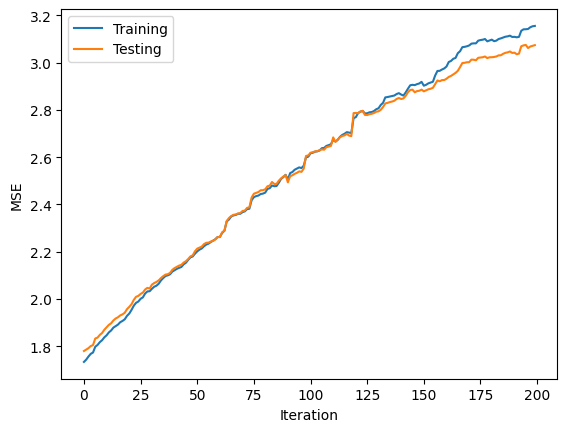

In [75]:
def PG(A, lam=.6, k=10, eta=1, threshold=100, max_iter=2000,
        replacement=False, give_updates=True, update_freq=200):
    """
    Projected Gradient of matrix A

    Args:
        A: dataset
        lam: regularization value
        k: dim for W, H factorization
        eta: learning rate
        threshold: threshold to determine stability, defaults to 100
        max_iter: maximum iterations to use, defaults to 0 (every pair)
        replacement: whether to pick pairs from Omega with replacement,
            defaults to False
        give_updates: whether to give updates when training, defaults to True
        update_freq: frequency to give updates between iterations, defaults to 5
    Returns:
        W: updated W
        H: updated H
    """
    # train test split
    train, test = create_train_test(A)

    # initialize W, H
    m,n = train.shape
    W = np.random.random((m,k))
    H = np.random.random((n,k))

    # initialize vector pairs, len = max_iter
    Omega_rows, Omega_cols = np.nonzero(train)
    Omega = list(zip(Omega_rows, Omega_cols))
    users = np.random.choice(Omega_rows, max_iter, replace=replacement)
    items = np.random.choice(Omega_cols, max_iter, replace=replacement)
    pairs = list(zip(users, items))

    # initial controls
    t = 0
    stabilized = False
    prev_stab = loss_sgd(train, W, H, lam, Omega)
    losses = [prev_stab]
    train_mses = []
    test_mses = []

    # update loop
    while not stabilized and t < max_iter:
        # get new pair
        u,i = pairs[t]

        # iterate t
        t += 1

        # update row u of W and row i of H  and replace negative values with 0
        W[u] = ((1-(lam*eta))*W[u]) - ((eta*(W[u].dot(H[i].T) - train[u,i]))*H[i])
        W[W<0] = 0
        H[i] = ((1-(lam*eta))*H[i]) - ((eta*(W[u].dot(H[i].T) - train[u,i]))*W[u])
        H[H<0] = 0

        # mses every 5 iterations
        if t%5==0:
            print(f"Iteration {t}")
            WH = W.dot(H.T)
            train_mses.append(MSE(train, WH))
            test_mses.append(MSE(test, WH))

        # only check loss and stability every 5 iterations
        if give_updates and t%update_freq==0:
            # calculate loss function value, uses same as the SGD
            loss = loss_sgd(A, W, H, lam, Omega)
            losses.append(loss)

            # calculate derivative
            diff = prev_stab - loss

            # check for stability
            if np.abs(diff) < threshold:
                stabilized = True
                print("Optimization stabilized!")
            elif t == max_iter:
                print("Optimization did not converge!")
                print(f"Max Iterations Reached (t={max_iter})")
            else:
                prev_stab = loss

            # update check-up
            print(f"Current Loss: {np.round(loss,3)}")
            print(f"Current Diff: {np.round(diff,3)}")
            print(f"Current Training MSE: {np.round(train_mses[-1],3)}")
            print(f"Current Testing MSE: {np.round(test_mses[-1],3)}")
        # end update loop
    # plots
    plt.plot(train_mses, label="Training")
    plt.plot(test_mses, label="Testing")
    plt.xlabel("Iteration")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

    return W, H

W_pg,H_pg = PG(R, max_iter=1000)

In [76]:
WH = W_pg.dot(H_pg.T)
print(f"Training MSE from ALS: {MSE(Rtrain, WH)}")
print(f"Testing MSE from ALS: {MSE(Rtest, WH)}")

Training MSE from ALS: 3.156181277346813
Testing MSE from ALS: 3.0563984784397378


#### **Recommendations**

The difference between the two inplementations is quite staggering. It seems the simple addition of not allowing negative values in the updated vectors makes a huge difference for the stability of the calculations.

Unfortunately, the MSE of this algorithm isn't an improvement. Every iteration projects the MSE to keep increasing. The outcomes are slightly better, but with the number of potential pairs to check being in the millions, this isn't a feasible algorithm to completely capture $R$.

In [77]:
preds_df = pd.DataFrame(WH, columns = R_df.columns)
already_rated, predictions = recommend_movies(preds_df, 837, movies_df, ratings_df, 10)
predictions

User 837 has already rated 69 movies.
Recommending highest 10 predicted ratings movies not already rated.


,MovieID,Title,Genres
253,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
877,899,Singin' in the Rain (1952),Musical|Romance
3233,3361,Bull Durham (1988),Comedy
47,50,"Usual Suspects, The (1995)",Crime|Thriller
1104,1136,Monty Python and the Holy Grail (1974),Comedy
1052,1084,Bonnie and Clyde (1967),Crime|Drama
1449,1517,Austin Powers: International Man of Mystery (1...,Comedy
1621,1704,Good Will Hunting (1997),Drama
2544,2657,"Rocky Horror Picture Show, The (1975)",Comedy|Horror|Musical|Sci-Fi
156,161,Crimson Tide (1995),Drama|Thriller|War


### **Conclusion**

We had a lucky first approach which beat the baseline we set above in the explicit ALS algorithm. While not a substantial improvement to the overall MSE, the recommendations are already in line with what user $837$ likes (Drama and Thriller), and the ALS recommendations improves on that demographic when compared to the Lee and Seung implementation.

Below we consider two random users ($428$ and $222$) to see if they have a similar relevance to their rated and recommended:

In [126]:
WH = W_als.dot(H_als.T)

In [127]:
preds_df = pd.DataFrame(WH, columns = R_df.columns)
already_rated, predictions = recommend_movies(preds_df, 428, movies_df, ratings_df, 10)
already_rated.head(10)

User 428 has already rated 50 movies.
Recommending highest 10 predicted ratings movies not already rated.


,UserID,MovieID,Rating,Timestamp,Title,Genres
0,428,2997,5,976260405,Being John Malkovich (1999),Comedy
2,428,3949,5,976260209,Requiem for a Dream (2000),Drama
13,428,1649,5,976260648,"Fast, Cheap & Out of Control (1997)",Documentary
4,428,593,5,976260880,"Silence of the Lambs, The (1991)",Drama|Thriller
5,428,778,5,976260296,Trainspotting (1996),Drama
11,428,1641,5,976260448,"Full Monty, The (1997)",Comedy
39,428,318,5,976260957,"Shawshank Redemption, The (1994)",Drama
48,428,1208,5,976260369,Apocalypse Now (1979),Drama|War
44,428,527,5,976260946,Schindler's List (1993),Drama|War
45,428,3742,5,976260880,"Battleship Potemkin, The (Bronenosets Potyomki...",Drama|War


In [128]:
predictions

,MovieID,Title,Genres
345,356,Forrest Gump (1994),Comedy|Romance|War
2492,2599,Election (1999),Comedy
593,608,Fargo (1996),Crime|Drama|Thriller
287,296,Pulp Fiction (1994),Crime|Drama
1162,1198,Raiders of the Lost Ark (1981),Action|Adventure
1699,1784,As Good As It Gets (1997),Comedy|Drama
1927,2028,Saving Private Ryan (1998),Action|Drama|War
1229,1270,Back to the Future (1985),Comedy|Sci-Fi
2652,2762,"Sixth Sense, The (1999)",Thriller
895,919,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical


In [123]:
preds_df = pd.DataFrame(WH, columns = R_df.columns)
already_rated, predictions = recommend_movies(preds_df, 222, movies_df, ratings_df, 10)
already_rated.head(10)

User 222 has already rated 80 movies.
Recommending highest 10 predicted ratings movies not already rated.


,UserID,MovieID,Rating,Timestamp,Title,Genres
1,222,1250,5,976835036,"Bridge on the River Kwai, The (1957)",Drama|War
6,222,589,5,976834465,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
15,222,592,5,976834933,Batman (1989),Action|Adventure|Crime|Drama
14,222,1198,5,976833993,Raiders of the Lost Ark (1981),Action|Adventure
12,222,590,5,976834687,Dances with Wolves (1990),Adventure|Drama|Western
13,222,1197,5,976834933,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
10,222,1266,5,976834667,Unforgiven (1992),Western
11,222,1196,5,976834465,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
38,222,2571,5,976834465,"Matrix, The (1999)",Action|Sci-Fi|Thriller
41,222,318,5,976834289,"Shawshank Redemption, The (1994)",Drama


In [124]:
predictions

,MovieID,Title,Genres
1213,1270,Back to the Future (1985),Comedy|Sci-Fi
106,110,Braveheart (1995),Action|Drama|War
1496,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
3613,3753,"Patriot, The (2000)",Action|Drama|War
2040,2161,"NeverEnding Story, The (1984)",Adventure|Children's|Fantasy
2839,2968,Time Bandits (1981),Adventure|Fantasy|Sci-Fi
3044,3175,Galaxy Quest (1999),Adventure|Comedy|Sci-Fi
1995,2115,Indiana Jones and the Temple of Doom (1984),Action|Adventure
830,858,"Godfather, The (1972)",Action|Crime|Drama
1985,2105,Tron (1982),Action|Adventure|Fantasy|Sci-Fi


User $428$ has a relatively high affinity for Drama, War and Comedy films, which is reflected well in their recommendations. User $222$, on the other hand, likes a lot of Action, Adventure and Sci-Fi movies, and is also similarly reflected well in their recommendations. It also goes without saying that the recommended films are, in their own right, very highly acclaimed, so these recommendations come from not only a place of relevance, but also quality.



---



---



---



---



# Part 2: Implicit Feedback Recommendation System



$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$

In many real-world applications, it’s expensive to collect explicit rating data. However,
it’s cheap to collect implicit feedback data such as clicks, page views, purchases and media
streams at a large and fast scale.

In this problem, you will learn more about implicit feedback recommendation systems by
focusing on Alternating Least Square (ALS) algorithm. Deriving the formula yourself by
following all the steps of the question and trying the algorithm on a real dataset will help
you understand how implicit feedback data can be used to learn more about users and items.

Let $U$ be a set of $m$ users, and $I$ be a set of $n$ items. For every user $u \in U$ and item $i \in I$,
let’s define such observable implicit feedback as $r_{ui}$:
- $r_{ui}$ = The number of times user $u$ interacted with item $i$.
Note that $r_{ui}$ could be allowed to have non-integer values; e.g. $r_{ui} = 0.5$ may indicate that
user $u$ watched half of movie $i$. We cannot observe the true preference $p_{ui}$ of user u for item
i. For simplicity, we assume $p_{ui}$ can only take the values 1 (like) or 0 (dislike).

Following the latent factor model in lecture, we assume $p_{ui}$ is the dot product of a user vector
$\m x_u \in \mb{R}^f$ and an item vector $\m y_i \in \mb{R}^f$
for each user $u$ and item $i$:
\begin{align}
p_{ui}\approx \m x_u^\top\m y_i
\end{align}

If user $u$ has interacted with item $i$, we have reason to believe that $p_{ui} = 1$ with some
confidence. The more the user interacts with that item, the more confident we are that $p_{ui}=1$.  To capture this idea, we try to minimize the following heuristic cost function over
possible assignments to the user matrix $\m{X}=\bcm \m{x}_1  & \dots & \m{x}_m\ecm^\top\in \mathbb{R}^{m\times f}$ and to the item matrix $\m{Y}=\bcm \m{y}_1  & \dots & \m{y}_n\ecm^\top \in \mathbb{R}^{n\times f}$:
\begin{align}
C_{implicit}(\m X, \m Y)= \sum_{u, i \in U\times I}c_{ui}(p_{ui}-\m x_u^\top\m y_i)^2 + \lambda \left(\sum_u\|\m x_u\|^2 + \sum_i \|\m y_i\|^2\right)
\end{align}
where
\begin{align}
p_{ui}= \begin{cases}1 & \text{if }r_{ui}>0 \\ 0 &\text{if }r_{ui}=0  \end{cases}
\end{align}

$c_{ui} = 1 + \alpha r_{ui}$ is our confidence in $p_{ui}$. Empirical evidence suggests setting hyperparameter
$\alpha$ to the sparsity ratio $=\frac{\text{#nonzero } r_{ui}}{\text{#zero }r_{ui} }$

We apply an algorithm known as Alternating Least Square (ALS) to minimize $C_{implicit}$. The
basic idea of ALS is: first hold the user vectors fixed and solve for the minimum in the item
variables, then hold the item vectors fixed and solve for the minimum in the user variables,
and repeat until convergence.

<img src="https://github.com/yexf308/PracticalML/blob/main/Homework/HW3/ALS.png?raw=true" width="800" />




---



---


## Warm up task 1: Theory  (15pt)

1. Treat $\m y_i$ as fixed for all $i ∈ I$. **Show** that the optimal $\m x_u$ with respect to the
cost function can be expressed as:
\begin{align}
\m x_u =\left(\m Y^\top \m C_u \m Y + \lambda \m I\right)^{-1}\m Y^\top \m C_u \m p_u
\end{align}
where $\m Y=\bcm \m y_1 & \dots & \m y_n\ecm^\top\in \mb{R}^{n\times f}, \m C_u= \text{diag}(c_{u1}, \dots, c_{un})\in \mb{R}^{n\times n}$ and $\m p_u=\bcm p_{u1} & \dots & p_{un}\ecm^\top \in \mb{R}^n$

2. For the calculation of $\m x_u$, a computational bottleneck is computing $\m Y^\top \m C_u \m Y$, where the naive solution requires time $O(nf^2)$. It’s because $\m Y^\top \m C_u \m Y$ has $f^2$ entries and
each entry requires $(3n − 1)$ operations (i.e., $2n$ multiplications and $n − 1$ additions). A
trick is to re-express $\m Y^\top \m C_u \m Y= \m Y^\top  \m Y+ \m Y^\top (\m C_u - I )\m Y$. Now $\m Y^\top  \m Y$ is independent of
$u$ and can be precomputed. Denote $n_u$ as the number of items $u$ iteracted with.

   - How many nonzero entries does $\m C_u − \m I$ have?

   - Assuming that $\m C_u − \m I$ is represented as a sparse matrix, derive that the time complexity of computing $\m Y^\top (\m C_u - I )\m Y$ for a single user $u$ is $O(n_uf^2)$. The real data set typically has $n_u\ll n$. We could see this trick significantly improves the naive solution which requires $O(nf^2)$. Similarly, we could use the same trick for $\m Y^\top \m C_u \m p_u$, where $\m Y^\top \m C_u \m p_u = \m Y^\top (\m C_u-\m I) \m p_u + \m Y^\top \m p_u$.



### Your Solution:

#### 1)

We recall our objective function:

\begin{align}
C_{implicit}(\m X, \m Y)= \sum_{u, i \in U\times I}c_{ui}(p_{ui}-\m x_u^\top\m y_i)^2 + \lambda \left(\sum_u\|\m x_u\|^2 + \sum_i \|\m y_i\|^2\right)
\end{align}

Since we are planning on taking the partial derivative with respect to one vector $\m x_u$ and $\frac{\partial}{\partial \m x_u} \lambda \left(\sum_u\|\m x_u\|^2 + \sum_i \|\m y_i\|^2\right) = 2\lambda \m x_u$, we need only simplify the first term in our objective function to a form that can be differentiated.

With $\m y_i$ fixed and letting $C^u = \text{diag}(c_u)$, we have:

\begin{align}
\sum_{u, i} c_{ui} (p_{ui} - \m x_u^\top \m y_i)^2 &= \sum_u c_u \|p_u - \m x_u^\top \m Y\|^2_2\\
&= \sum_u c_u (p_u - \m x_u^\top\m Y)(p_u -\m x_u^\top\m Y)^\top\\
&= \sum_u c_u (p_u p_u^\top - p_u \m Y^\top \m x_u - p_u^\top \m x_u^\top\m Y + \m x_u^\top\m Y \m Y^\top \m x_u)\\
L :&= \sum_u p_u C^u p_u^\top - 2 \m x_u \m Y^\top C^u p_u^\top  + \m x_u \m Y^\top C^u \m Y \m x_u^\top,\\
\end{align}

With partial derivative:
\begin{align}
\frac{\partial L}{\partial \m x_u} = - 2 \m Y^\top C^u p_u^\top  + 2 \m Y^\top C^u \m Y \m x_u.
\end{align}

So, to find optimal $\m x_u$, set $\frac{\partial C_{implicit} }{\partial \m x_u}=0$ and solve for $\m x_u$:

\begin{align}
\frac{\partial C_{implicit}}{\partial \m x_u} &= - 2 \m Y^\top \m C^u \m p_u^\top + 2 \m Y^\top \m C^u \m Y \m x_u + 2\lambda \m x_u = 0\\
&\Rightarrow \m Y^\top \m C^u \m Y \m x_u + \lambda \m I \m x_u = \m Y^\top \m C^u \m p_u^\top\\
\\
&\Rightarrow (\m Y^\top \m C^u \m Y \m + \lambda \m I) \m x_u = \m Y^\top \m C^u \m p_u^\top\\
\\
&\Rightarrow \m x_u = (\m Y^\top \m C^u \m Y \m + \lambda \m I)^{-1}\m Y^\top \m C^u \m p_u^\top.\\
\end{align}


#### 2)

* Recall that $\m C_u$ is a diagonal matrix (i.e all non-diagonal entries are $0$) corresponding to $c_u,$ where for fixed $u$, $c_{u,i} = 1+\alpha r_{u,i}$, with $\alpha > 0$ the sparcity hyperparameter and $r_{u,i}$ an entry in $\m R$.

 If $r_{u,i}>0,$ then $c_{u,i}>1,$ so the diagonal entry of $\m C_{u,i}>0.$ If $r_{u,i}=0,$ then $c_{u,i}=1,$ so the diagonal entry of $\m C_{u,i}=1,$ thus $\m C_u − \m I$ has $0$ entry at $(\m C_u −\m I)_{u,i}$. Therefore, $\m C_u − \m I$ has a number of nonzero entries equal to the number of nonzero entries in $\m R_u$ (or, the number of interacted items for user $u$ in $\m R$), which we'll denote as $n_u$.

* Recall that $\m Y=\bcm \m y_1 & \dots & \m y_n\ecm^\top\in \mb{R}^{n\times f}$ and $\m C_u= \text{diag}(c_{u1}, \dots, c_{un})\in \mb{R}^{n\times n}$. Since $\m C^u$ is diagonal, we can rewrite the multiplication of $\m Y^\top (\m C_u − \m I) \m Y$ as:
\begin{align}
\sum_i (c_{u,i} - 1) y_i^\top  y_i = \sum_i (c_{u,i} - 1) \|y_i\|^2_2,
\end{align}
where we can check for each $i$ if $c_{u,i}-1=0.$ If it is, we can skip the calculation of $\|y_i\|^2_2.$ We can define an index list $I_u$ to restrict the summation to just the $n_u$ nonzero entries in $\m C^u - \m I.$

 Since each $y_i \in \mb{R}^f, \|y_i\|^2_2 = O(f^2),$ and since we do this multiplication $n_u$ times, we have:

 \begin{align}
 \m Y^\top (\m C_u − \m I) \m Y = \sum_{i\in I_u} (c_{u,i} - 1) y_i^\top  y_i = \sum_{i\in I_u} (c_{u,i} - 1) \|y_i\|^2_2 = O(n_uf^2).
 \end{align}




---



---



## Task 2: Implementation (25pt)

We have provided a real dataset (`user_artists.txt`)  containing the listening history of 3000 artists from 1882 users in Last.fm3. The
file contains tab-separated triplets (one triplet per line) of the form $< u, i, r_{ui} >$, where
$u$ is a user label, $i$ is an artist label and $r_{ui}$ is the number of time user $u$ interacted with
artist $i$ (e.g. listened to him). The file `artists.txt` contains tab-separated pairs (one
pair per line) of the form $ < i, s_i >$, where $i$ is an artist and $s_i$
is the name of the artist.
We also provide a smaller dataset (`user_artists_small.txt`) for sanity check, which
contains 100 artists and 100 users.

For the two datasets, calculate the sparsity ratio:
\begin{align}
\alpha = \frac{\sum_{ui\in U\times I} \mathbb{1}[r_{ui}>0]}{\sum_{ui\in U\times I} \mathbb{1}[r_{ui}=0]}
\end{align}

Then, implement the implicit feedback recommendation system via ALS for this dataset. Here we assume $f = 3$ and $λ = 0.01.$ For initialization, set $\m X^{(0)}$ as a matrix with all elements = 0.5 and $\m Y^{(0)}$ as a zero matrix. You have been provided a skeleton in the following code. Complete the function ALS. Note
that the template does not include code for other functions, such as reading the file,
calculating the objective function, running iterations.  You need to implement all the
other necessary functions yourself. Answer the following questions:

Run your program for 100 iterations.
1. What’s initial $C_{implicit}$?

2. What’s $C_{implicit}$ after the 1st iteration?

3. Plot the value of the objective function $C_{implicit}$ t as a function of the number of iterations.

4. Report top 2 favorite artists for user 0, 20 after the 1st and 100th
iterations.

See below for additional instructions on what to report. We found that there might be subtle variations in the final values based on the implementation and runtime environment. For minimizing these variations, please follow
these instructions:

- Please do not round off values at any stage including the sparsity ratio (compute
it programmatically). Also, avoid using explicit floating point precision typecasting
such as `dtype=np.float32`.

- In your implementation, please store $\m X, \m Y , \m C_i−\m I$ and $\m C_u−\m I$ as sparse matrix. You
may use `csr_matrix` in library `scipy.sparse`. And please use `scipy.sparse.linalg.spsolve`
to solve and update $\m x_u$ and $\m y_i$

- To speed up your implementation, you should avoid using converting functions such
as `toarray()` and `todense()` within any for loop.

**Note:** Taking these subtle variations into account, we defined a longer list of potential
top 3 recommendations for each user. Your predictions for each user are expected to
be within these lists even though the ordering of the top recommendations might show
small variations depending on the implementation and runtime environment.

**Hint 1:** For the user `artists_small.txt` dataset, after 1 iteration, $C_{implicit}$ is between
1400 and 1600, after 100 iterations, the top 5 favorite artists for user 1 include 30 and
95.

**Hint 2:** Use the trick from task 1 to speed up your implementation. The expected run
time for the the user artists.txt dataset is 10-15 minutes.

In [84]:
!wget https://raw.githubusercontent.com/yexf308/PracticalML/main/Homework/HW3/artists.txt?raw=true -O artists.txt
!wget https://raw.githubusercontent.com/yexf308/PracticalML/main/Homework/HW3/user_artists_small.txt?raw=true -O user_artists_small.txt
!wget https://raw.githubusercontent.com/yexf308/PracticalML/main/Homework/HW3/user_artists.txt?raw=true -O user_artists.txt



--2025-04-17 03:26:07--  https://raw.githubusercontent.com/yexf308/PracticalML/main/Homework/HW3/artists.txt?raw=true
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52777 (52K) [text/plain]
Saving to: ‘artists.txt’

artists.txt         100%[===================>]  51.54K  --.-KB/s    in 0.01s   

2025-04-17 03:26:07 (4.10 MB/s) - ‘artists.txt’ saved [52777/52777]

--2025-04-17 03:26:07--  https://raw.githubusercontent.com/yexf308/PracticalML/main/Homework/HW3/user_artists_small.txt?raw=true
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [85]:
Data_lg=np.loadtxt('user_artists.txt',skiprows=1, dtype='i4')
print(Data_lg.shape)
df_lg = pd.DataFrame(Data_lg, columns=['userID', 'artistID', 'interactions'])
df_lg.head()

(62894, 3)


,userID,artistID,interactions
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983


In [86]:
Data_sm=np.loadtxt('user_artists_small.txt',skiprows=1, dtype='i4')
print(Data_sm.shape)
df_sm = pd.DataFrame(Data_sm, columns=['userID', 'artistID', 'interactions'])
df_sm.head()

(265, 3)


,userID,artistID,interactions
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983


In [87]:
Data_artists = pd.read_csv('artists.txt', sep='\t')
Data_artists['artistID'] = Data_artists['artistID'].apply(pd.to_numeric)
Data_artists

,artistID,name
0,0,MALICE MIZER
1,1,Diary of Dreams
2,2,Carpathian Forest
3,3,Moi dix Mois
4,4,Bella Morte
...,...,...
2995,2995,Benny Goodman
2996,2996,Jimmie Rodgers
2997,2997,Eddie Bo
2998,2998,Botswana Music Guitar


In [88]:
def C_implicit(X, Y, P, C, m, n, lam):
    # not very efficient (30 seconds per iteration)
    X = X.toarray()
    Y = Y.toarray()
    P = P.toarray()
    left = 0
    for u in range(m):
        for i in range(n):
            if P[u,i] == 1:
                left += C[u,i] * (1 - np.dot(X[u], Y[i]))**2
            else:
                left += C[u,i] * (np.dot(X[u], Y[i]))

    right = lam * (LA.norm(X, 'fro')**2 + LA.norm(Y, 'fro')**2)
    return left + right


def ALS_imp(X, Y, P, C, f=3, lam=.01, max_iter = 100, timer=False):
    """
    ALS for a given preference and confidence matrix

    Args:
        X: user matrix to be updated
        Y: item matrix to be updated
        P: preference matrix
        C: confidence matrix
        f: number of latent factors, defaults to 3
        lam: regularization parameter, defaults to .01
        MAX_ITER: maximum number of iterations, defaults to 10
        timer: whether to time each iteration, defaults to False
    Returns:
        X: updated user matrix
        Y: updated item matrix
    """
    # construct lambda * I
    lamI = sparse.csc_matrix(lam*np.eye(f))

    # m and n
    m = X.shape[0]
    n = Y.shape[0]

    # C_implicit list
    C_imp = [C_implicit(X, Y, P, C, m, n, lam)]

    for t in range(max_iter):
        if timer:
            print(f"Iteration {t+1}")
            begin = time.time()
        else:
            print(f"Iteration {t+1}")

        # update item matrix
        xTx = X.T.dot(X)
        for item in range(n):
            p_i = P[:, item]
            C_i = C[:, item].reshape(m,1)
            C_i_I = C_i - 1

            left = xTx + X.T @ (X.multiply(C_i_I)) + lamI
            right = X.T @ (p_i.multiply(C_i))

            y_i = sparse.linalg.inv(left) @ right
            Y[item] = y_i.T
            # end item loop
        print("updated item matrix")
        # update user matrix
        yTy = Y.T.dot(Y)
        for user in range(m):
            p_u = P[user, :]
            C_u = C[user, :].reshape(n,1)
            C_u_I = C_u - 1

            left = yTy + Y.T @ (Y.multiply(C_u)) + lamI
            right = Y.T @ ((p_u.T).multiply(C_u))
            x_u = sparse.linalg.inv(left) @ right

            X[user] = x_u.T
            # end user loop
        print("updated user matrix")
        if timer:
            t2 = time.time()
            print(f"Time taken for iteration {t+1}: {np.round(t2 - begin,1)}")

        # C implicit
        C_imp.append(C_implicit(X, Y, P, C, m, n, lam))

        # capturing iteration 1 X,Y updates
        if t == 0:
            X_one = X.copy()
            Y_one = Y.copy()
        # end iteration

    return X_one, Y_one, X, Y, C_imp

m = 1882
n = 3000
f=3
lam=.01
X_init = sparse.csr_matrix(np.zeros((m, f)) + 0.5)
Y_init = sparse.csr_matrix(np.zeros((n, f)))

# YOUR CODE HERE

df = df_lg.copy()

# initialize A matrix and nonzero vector
A = np.zeros((m, n))
nonzero = np.zeros(m)

# creating A matrix
for u in range(m):
	# restrict the data to just the user
	temp_df = df.loc[df['userID'] == u]
	# get artist and interaction data from temp list
	artists = temp_df['artistID'].to_numpy()
	interactions = temp_df['interactions'].to_numpy()
	# make A, keep track of nonzero entries per row
	for i in range(len(artists)):
		A[u, artists[i]] += interactions[i]
	# indexes to one below the number of artists (indexing by 0)
	nonzero[u] = i+1

# sparcity hyperparameter
alpha = np.sum(nonzero) / np.sum(n-nonzero)

# creating P based on nonzero entries of A
P = np.zeros((m, n))
P = np.where(A > 0, 1, 0)
P = sparse.csr_matrix(P)

# creating C based on A and alpha
# NOT a sparce matrix, for elementwise multiplication and reshaping in ALS
C = np.zeros((m, n))
C = np.where(A > 0, 1 + (alpha * A), 1)

# calculate ALS
X_one, Y_one, X_up, Y_up, C_imp = ALS_imp(X_init,Y_init,P,C,max_iter=100)


Iteration 1


/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


updated item matrix
updated user matrix
Iteration 2
updated item matrix
updated user matrix
Iteration 3
updated item matrix
updated user matrix
Iteration 4
updated item matrix
updated user matrix
Iteration 5
updated item matrix
updated user matrix
Iteration 6
updated item matrix
updated user matrix
Iteration 7
updated item matrix
updated user matrix
Iteration 8
updated item matrix
updated user matrix
Iteration 9
updated item matrix
updated user matrix
Iteration 10
updated item matrix
updated user matrix
Iteration 11
updated item matrix
updated user matrix
Iteration 12
updated item matrix
updated user matrix
Iteration 13
updated item matrix
updated user matrix
Iteration 14
updated item matrix
updated user matrix
Iteration 15
updated item matrix
updated user matrix
Iteration 16
updated item matrix
updated user matrix
Iteration 17
updated item matrix
updated user matrix
Iteration 18
updated item matrix
updated user matrix
Iteration 19
updated item matrix
updated user matrix
Iteration 20
u

In [95]:
## initial C_imp
print("Initial C_implicit", C_imp[0])
print("First Iteration C_implicit", C_imp[1])
print("Final C_implicit", C_imp[-1])

Initial C_implicit 685918.6402882533
First Iteration C_implicit 479789.17056147516
Final C_implicit 397019.76939272985


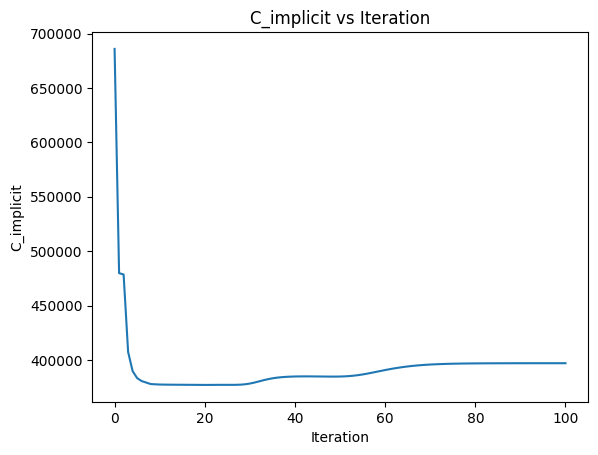

In [89]:
plt.plot(range(0,101), C_imp)
plt.xlabel('Iteration')
plt.ylabel('C_implicit')
plt.title('C_implicit vs Iteration')
plt.show()

In [90]:
def recommend_artists(preds_df, userID, artists_df, user_artists_df, num_recommendations=5):

    # Get and sort the user's predictions
    sorted_user_predictions = preds_df.iloc[userID].sort_values(ascending=False)

    # Get the user's data and merge in the movie information.
    user_data = user_artists_df[user_artists_df.userID == (userID)]
    user_full = (user_data.merge(artists_df, how = 'left', left_on = 'artistID', right_on = 'artistID').
                     sort_values(['interactions'], ascending=False)
                 )

    print('User {0} has already heard {1} artists.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted artists not already rated.'.format(num_recommendations))

    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (artists_df[~artists_df['artistID'].isin(user_full['artistID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'artistID',
               right_on = 'artistID').
         rename(columns = {userID: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

XY_one = (X_one @ Y_one.T).toarray()
preds_df_one = pd.DataFrame(XY_one, columns = Data_artists['artistID'])
XY = (X_up @ Y_up.T).toarray()
preds_df = pd.DataFrame(XY, columns = Data_artists['artistID'])

num_preds = 5


In [91]:
## Top 5 Predictions for User 0 after 1 Iteration
already_rated, predictions = recommend_artists(preds_df_one, 0, Data_artists, df_lg, num_preds)
predictions

User 0 has already heard 50 artists.
Recommending highest 5 predicted artists not already rated.


,artistID,name
233,283,Britney Spears
236,286,Christina Aguilera
232,282,Rihanna
442,492,Paramore
171,221,The Beatles


In [92]:
## Top 5 Predictions for User 0 after 100 Iterations
already_rated, predictions = recommend_artists(preds_df, 0, Data_artists, df_lg, num_preds)
predictions

User 0 has already heard 50 artists.
Recommending highest 5 predicted artists not already rated.


,artistID,name
131,181,a-ha
1039,1089,Björk
98,148,Radiohead
1979,2029,Sarah Brightman
147,197,Blur


In [93]:
## Top 5 Predictions for User 20 after 1 Iteration
already_rated, predictions = recommend_artists(preds_df_one, 20, Data_artists, df_lg, num_preds)
predictions

User 20 has already heard 50 artists.
Recommending highest 5 predicted artists not already rated.


,artistID,name
273,283,Britney Spears
81,83,Lady Gaga
276,286,Christina Aguilera
272,282,Rihanna
480,492,Paramore


In [94]:
## Top 5 Predictions for User 20 after 100 Iterations
already_rated, predictions = recommend_artists(preds_df, 20, Data_artists, df_lg, num_preds)
predictions

User 20 has already heard 50 artists.
Recommending highest 5 predicted artists not already rated.


,artistID,name
145,148,Radiohead
195,201,Arctic Monkeys
162,167,Placebo
178,184,Muse
514,527,Oasis


### Describe your findings:

1.   $C^0_{implicit} = 685918.64$
2.   $C^1_{implicit} = 479789.17$
3.   See Plots above
4.   User $0$ had recommended artists *Britney Spears* and *Christina Aguilera*
 after one iteration, *a-ha* and *Björk* after full training.

 User $20$ had recommended artists *Britney Spears* and *Lady Gaga* after one iteration, *Radiohead* and *Arctic Monkeys* after full training.

Overall, given the converging values of $C_{implicit}$, we can likely conclude that the recommendations from this model are good. The first iteration recommendations are expected to be from some of the most popular artists, regardless of genre, as we have not trained as much as we could to gather genre data. Once we iterate a lot, we can see that the genres of the artists recommended converge to artists within the genres in line with what the user's are currently interacting with.

Just to check my work, below is the same base method for ALS, but the $C_{implicit}$ function was made more efficient by ChatGPT. The outputs are slightly different even though the training is the same, which makes me second guess my implementation, but I would be remiss if I didn't consider the output(especially since $C^0_{implicit}$ is identical and the calculation time is practically instant).

In [115]:
def C_implicit_gpt(X, Y, P, C, lam):
    # Compute the predicted interaction matrix (X * Y^T), as dense matrix
    XY = X @ Y.T  # Result is sparse
    XY_dense = XY.toarray()  # Small dense matrix (m x n)

    # --- Positive preference part: P[u,i] == 1 ---
    pu_i = P.nonzero()  # Tuple of arrays (row indices, col indices)
    pred_vals = XY_dense[pu_i]
    conf_vals = C[pu_i].flatten()  # Flatten to 1D
    errors = 1 - pred_vals
    left_pos = np.sum(conf_vals * errors**2)

    # --- Negative preference part: P[u,i] == 0 ---
    # Do this by using the sparsity of (C - P)
    C_minus_P = C - P  # Still sparse
    cmi_i = C_minus_P.nonzero()
    pred_vals_neg = XY_dense[cmi_i]
    conf_vals_neg = C_minus_P[cmi_i].A1
    left_neg = np.sum(conf_vals_neg * pred_vals_neg)

    left = left_pos + left_neg

    # Regularization: Frobenius norm of X and Y
    right = lam * (
        np.sum(X.multiply(X)) + np.sum(Y.multiply(Y))
    )

    return left + right

def ALS_imp_gpt(X, Y, P, C, f=3, lam=.01, max_iter = 100, timer=False):
    """
    ALS for a given preference and confidence matrix

    Args:
        X: user matrix to be updated
        Y: item matrix to be updated
        P: preference matrix
        C: confidence matrix
        f: number of latent factors, defaults to 3
        lam: regularization parameter, defaults to .01
        MAX_ITER: maximum number of iterations, defaults to 10
        timer: whether to time each iteration, defaults to False
    Returns:
        X: updated user matrix
        Y: updated item matrix
    """
    # construct lambda * I
    lamI = sparse.csc_matrix(lam*np.eye(f))

    # m and n
    m = X.shape[0]
    n = Y.shape[0]

    # C_implicit list
    C_imp_gpt = [C_implicit_gpt(X, Y, P, C, lam)]
    print("Initial C_implicit", C_imp_gpt[0])

    for t in range(max_iter):
        if timer:
            print(f"Iteration {t+1}")
            begin = time.time()
        else:
            print(f"Iteration {t+1}")

        # update item matrix
        xTx = X.T.dot(X)
        for item in range(n):
            p_i = P[:, item]
            C_i = C[:, item].reshape(m,1)
            C_i_I = C_i - 1

            left = xTx + X.T @ (X.multiply(C_i_I)) + lamI
            right = X.T @ (p_i.multiply(C_i))

            y_i = sparse.linalg.inv(left) @ right
            Y[item] = y_i.T
            # end item loop
        print("updated item matrix")
        # update user matrix
        yTy = Y.T.dot(Y)
        for user in range(m):
            p_u = P[user, :]
            C_u = C[user, :].reshape(n,1)
            C_u_I = C_u - 1

            left = yTy + Y.T @ (Y.multiply(C_u)) + lamI
            right = Y.T @ ((p_u.T).multiply(C_u))
            x_u = sparse.linalg.inv(left) @ right

            X[user] = x_u.T
            # end user loop
        print("updated user matrix")
        if timer:
            t2 = time.time()
            print(f"Time taken for iteration {t+1}: {np.round(t2 - begin,1)}")

        # C implicit
        C_imp_gpt.append(C_implicit_gpt(X, Y, P, C, lam))
        print("Current C_implicit", C_imp_gpt[-1])

        # capturing iteration 1 X,Y updates
        if t == 0:
            X_one_gpt = X.copy()
            Y_one_gpt = Y.copy()
        # end iteration

    return X_one_gpt, Y_one_gpt, X, Y, C_imp_gpt


m = 1882
n = 3000
f=3
lam=.01
X_init_gpt = sparse.csr_matrix(np.zeros((m, f)) + 0.5)
Y_init_gpt = sparse.csr_matrix(np.zeros((n, f)))

# YOUR CODE HERE

df = df_lg.copy()

# initialize A matrix and nonzero vector
A = np.zeros((m, n))
nonzero = np.zeros(m)

# creating A matrix
for u in range(m):
	# restrict the data to just the user
	temp_df = df.loc[df['userID'] == u]
	# get artist and interaction data from temp list
	artists = temp_df['artistID'].to_numpy()
	interactions = temp_df['interactions'].to_numpy()
	# make A, keep track of nonzero entries per row
	for i in range(len(artists)):
		A[u, artists[i]] += interactions[i]
	# indexes to one below the number of artists (indexing by 0)
	nonzero[u] = i+1

# sparcity hyperparameter
alpha = np.sum(nonzero) / np.sum(n-nonzero)

# creating P based on nonzero entries of A
P = np.zeros((m, n))
P = np.where(A > 0, 1, 0)
P = sparse.csr_matrix(P)

# creating C based on A and alpha
# NOT a sparce matrix, for elementwise multiplication and reshaping in ALS
C = np.zeros((m, n))
C = np.where(A > 0, 1 + (alpha * A), 1)

# calculate ALS
X_one_gpt, Y_one_gpt, X_up_gpt, Y_up_gpt, C_imp_gpt = ALS_imp_gpt(X_init_gpt,Y_init_gpt,P,C,max_iter=25)

Initial C_implicit 685918.6402882535
Iteration 1
updated item matrix
updated user matrix
Current C_implicit 771825.6213516796
Iteration 2
updated item matrix
updated user matrix
Current C_implicit 779304.4869840778
Iteration 3
updated item matrix
updated user matrix
Current C_implicit 746296.3231547305
Iteration 4
updated item matrix
updated user matrix
Current C_implicit 736399.7241164463
Iteration 5
updated item matrix
updated user matrix
Current C_implicit 732642.6225589185
Iteration 6
updated item matrix
updated user matrix
Current C_implicit 731288.4705432518
Iteration 7
updated item matrix
updated user matrix
Current C_implicit 731074.0200862993
Iteration 8
updated item matrix
updated user matrix
Current C_implicit 730792.4849266892
Iteration 9
updated item matrix
updated user matrix
Current C_implicit 731231.7085733123
Iteration 10
updated item matrix
updated user matrix
Current C_implicit 731126.9086868343
Iteration 11
updated item matrix
updated user matrix
Current C_implicit 

Below are the recommendations after $1$ and $25$ iterations for user $20$ for comparison:

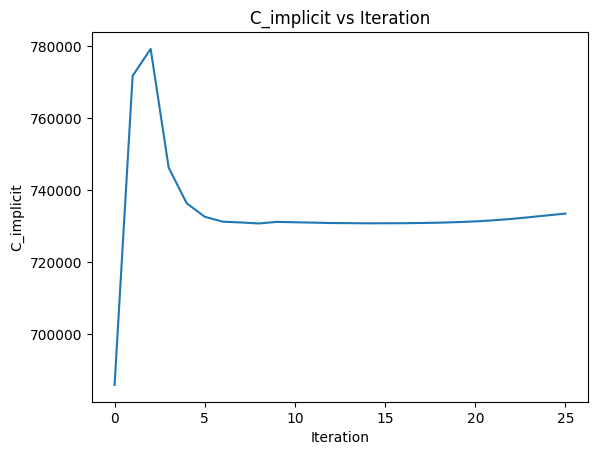

In [120]:
plt.plot(range(0,26), C_imp_gpt)
plt.xlabel('Iteration')
plt.ylabel('C_implicit')
plt.title('C_implicit vs Iteration')
plt.show()

In [116]:
XY_one = (X_one_gpt @ Y_one_gpt.T).toarray()
preds_df_one = pd.DataFrame(XY_one, columns = Data_artists['artistID'])
XY = (X_up_gpt @ Y_up_gpt.T).toarray()
preds_df = pd.DataFrame(XY, columns = Data_artists['artistID'])

num_preds = 5

In [117]:
## Top 5 Predictions for User 20 after 1 Iteration
already_rated, predictions = recommend_artists(preds_df_one, 20, Data_artists, df_lg, num_preds)
predictions

User 20 has already heard 50 artists.
Recommending highest 5 predicted artists not already rated.


,artistID,name
273,283,Britney Spears
81,83,Lady Gaga
276,286,Christina Aguilera
272,282,Rihanna
480,492,Paramore


In [118]:
## Top 5 Predictions for User 20 after 1 Iteration
already_rated, predictions = recommend_artists(preds_df, 20, Data_artists, df_lg, num_preds)
predictions

User 20 has already heard 50 artists.
Recommending highest 5 predicted artists not already rated.


,artistID,name
145,148,Radiohead
195,201,Arctic Monkeys
407,418,The Strokes
178,184,Muse
162,167,Placebo


As expected, the recommendations are the same (since training wasn't changed), but the $C_{implicit}$ values are different. Since our original calculator was very inefficient, but term for term accurate, we expect there to be some error in the ChatGPT implementation, but without digging, it would be hard to find where it's wrong. The digging would be worth it given its very low runtime.